<a href="https://colab.research.google.com/github/peacebefore/snoop/blob/main/Snoop_Dog_Breed_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Snoop, the Dog Breed Identifier

**Project Goal:**
Identify a dog's breed by providing an image of the dog.

**Implementation:**
In this project, I'll use TensorFlow to preprocess the data and transfer learning to leverage the patterns of a model from TensorFlow Hub which has been trained to classify images.

**Data Source:** The [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

In [ ]:
# Mounting my Google Drive where the data is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "yes, available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.14.0
Hub version: 0.15.0
GPU yes, available


### Accessing the data

The `labels.csv` contains all of the image ID's and their associated dog breed (the data and labels).

In [ ]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Vision/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


Looking at this, I can see there are 10,222 different images and 120 different breeds.

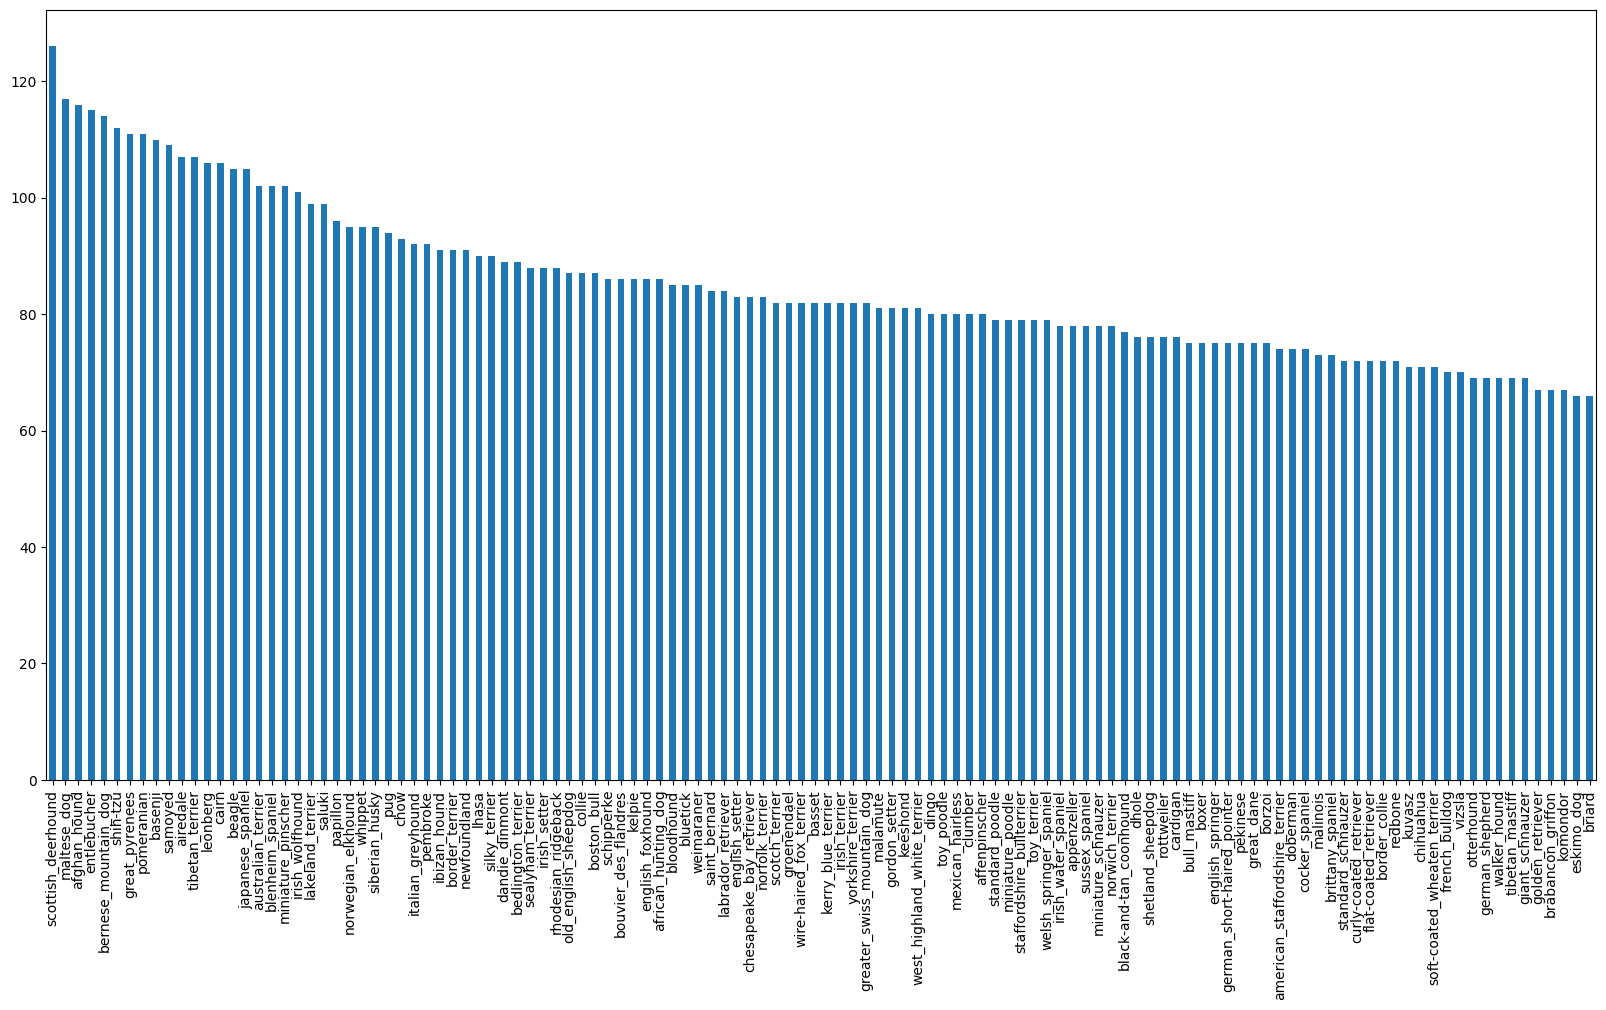

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

It looks like there are about 60+ images for each dog breed.

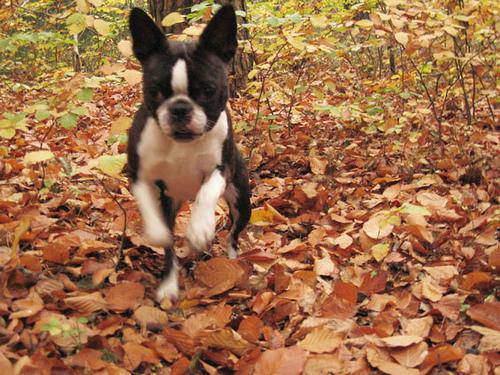

In [ ]:
from IPython.display import display, Image
Image("/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

I'll use the DataFrame of the image ID's and their labels to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

In [ ]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10 filenames
filenames[:10]

['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Dog Vision/dog-breed-identification/train")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


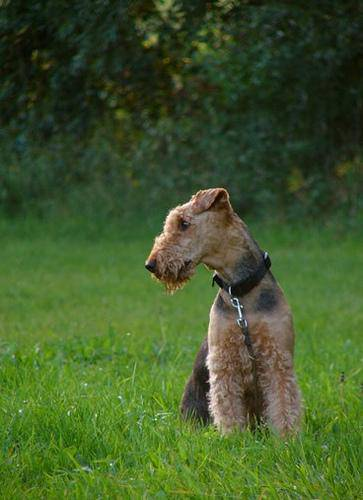

In [ ]:
# Check an image directly from a filepath
Image(filenames[102])

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating a validation set

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

Now I'll split the data into training and validation sets. I'll use and 80/20 split (80% training data, 20% validation data).

In [ ]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/Dog Vision/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, Fa

### Preprocessing images (turning images into Tensors)


In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

### Creating data batches

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, there are no labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, no need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing data batches

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

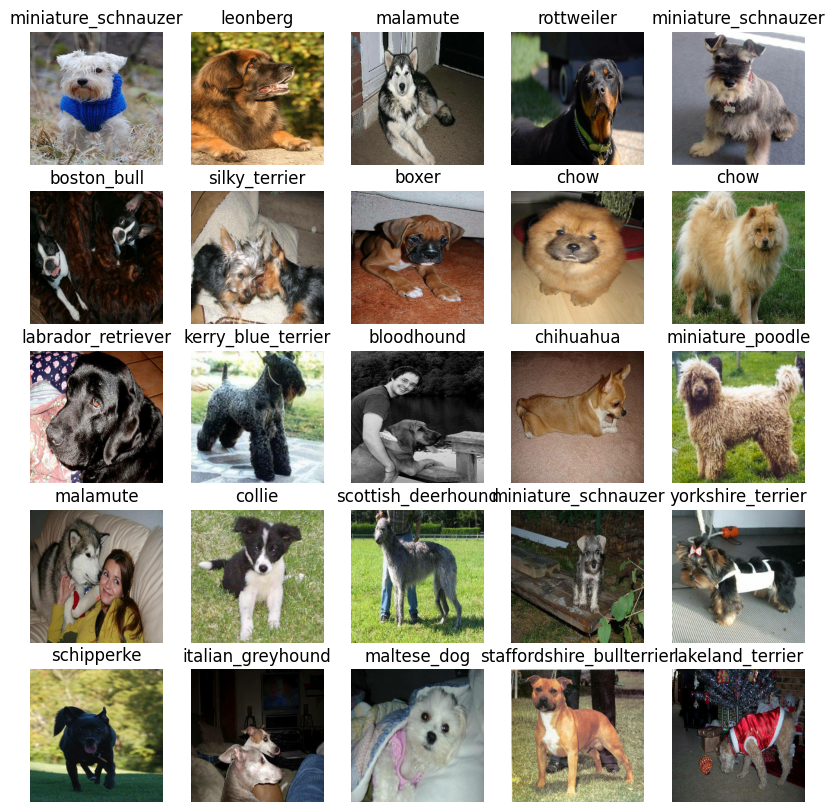

In [ ]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

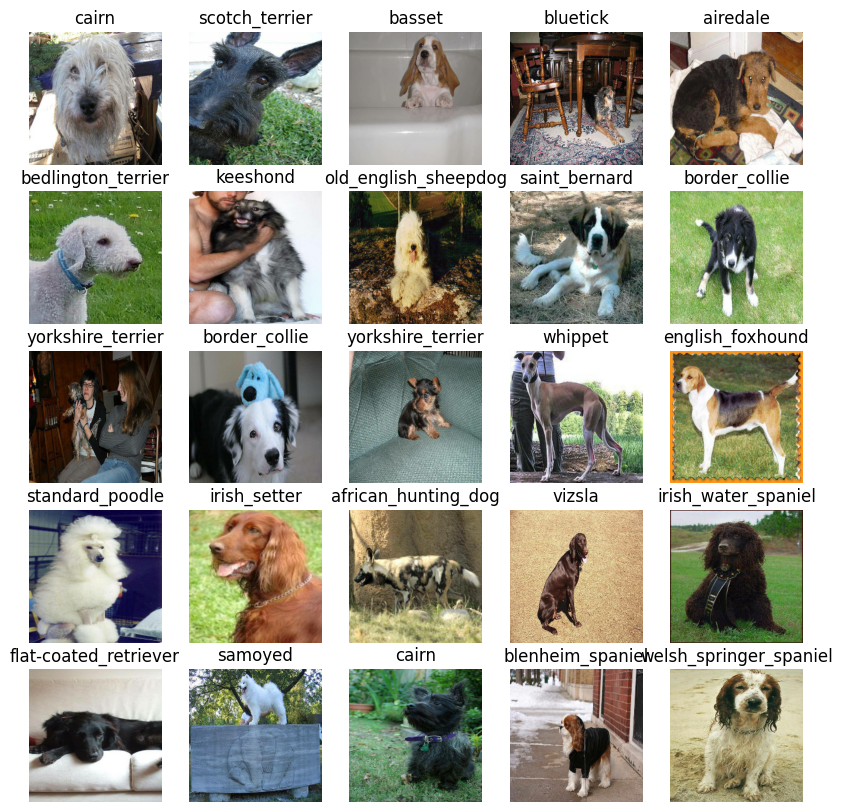

In [ ]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Creating and training a model

I'll use an existing model from [TensorFlow Hub](https://tfhub.dev/).

The [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) model takes an input of images in the shape 224, 224. It has also been trained in the domain of image classification.


In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
# Create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


#### Early Stopping Callback



In [ ]:
# Create early stopping (once the model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

### Training a model (on a subset of data)

In [ ]:
# Check again if GPU is available
print("GPU", "yes, available" if tf.config.list_physical_devices("GPU") else "not available")

GPU yes, available


In [ ]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime the model is trained
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 186s 7s/step - loss: 4.6440 - accuracy: 0.1037 - val_loss: 3.5738 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 3s 110ms/step - loss: 1.6693 - accuracy: 0.6825 - val_loss: 2.2503 - val_accuracy: 0.4750
Epoch 3/100
25/25 [==============================] - 3s 105ms/step - loss: 0.5727 - accuracy: 0.9413 - val_loss: 1.7310 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 3s 139ms/step - loss: 0.2480 - accuracy: 0.9962 - val_loss: 1.5618 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 4s 140ms/step - loss: 0.1458 - accuracy: 1.0000 - val_loss: 1.4579 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 3s 103ms/step - loss: 0.1001 - accuracy: 1.0000 - val_loss: 1.4102 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================]

## Making and evaluating predictions using a trained model

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 83ms/step


array([[1.3870953e-03, 4.2725500e-05, 8.7769481e-04, ..., 6.3118525e-04,
        7.2921386e-05, 5.4500606e-03],
       [2.6029451e-03, 1.4817724e-03, 1.9960128e-02, ..., 1.2342199e-03,
        5.8812671e-03, 3.1080807e-04],
       [2.4018946e-06, 6.0077833e-05, 3.4900163e-06, ..., 6.9920416e-06,
        7.6684018e-06, 9.5613505e-05],
       ...,
       [1.5933381e-06, 7.3542491e-05, 3.0206165e-05, ..., 6.0353195e-06,
        2.4435703e-05, 2.8837705e-06],
       [1.3300125e-02, 1.5709546e-04, 1.4814312e-04, ..., 2.3622767e-04,
        1.4730588e-04, 2.1117691e-02],
       [2.0807823e-04, 2.0169296e-05, 8.5952727e-04, ..., 8.0699567e-03,
        3.7960830e-04, 9.9024146e-06]], dtype=float32)

In [ ]:
# Check the shape of predictions
predictions.shape

(200, 120)

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # this should be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[1.3870953e-03 4.2725500e-05 8.7769481e-04 6.0656654e-05 2.8825225e-05
 2.5999605e-05 2.2622745e-02 3.2863935e-04 1.7491853e-05 7.4060546e-04
 1.1308128e-03 1.9588182e-04 1.9763959e-04 6.7417590e-05 2.5888949e-03
 7.2559546e-04 3.3059379e-05 5.6903757e-02 2.2187249e-05 4.9944410e-05
 5.6350569e-04 2.2212826e-04 3.6298898e-05 9.8787621e-04 2.1265580e-05
 1.1417690e-04 2.8480494e-01 7.5341137e-05 3.3295478e-04 1.2952223e-04
 8.7295528e-05 7.5430638e-04 5.7846075e-04 1.3213168e-05 2.9914292e-05
 8.5145719e-03 1.5355752e-05 1.4805705e-04 7.0080841e-06 1.7590704e-04
 2.2739674e-04 3.3477158e-05 1.4394507e-04 1.6822580e-03 1.0248656e-05
 9.2420516e-05 6.2251943e-06 8.2056475e-05 5.7328073e-04 1.9043681e-04
 4.7480749e-04 1.3098927e-04 1.4157988e-04 1.5096253e-04 8.1553510e-05
 5.1515664e-05 1.2741158e-04 8.2111004e-04 5.6561007e-04 2.6814005e-01
 2.6262880e-04 4.6278419e-05 3.8531437e-04 1.7419209e-04 5.1844009e-04
 3.8139705e-02 7.3772579e-05 2.6988084e-04 8.3661731e-03 1.4519448e-04
 1.537

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

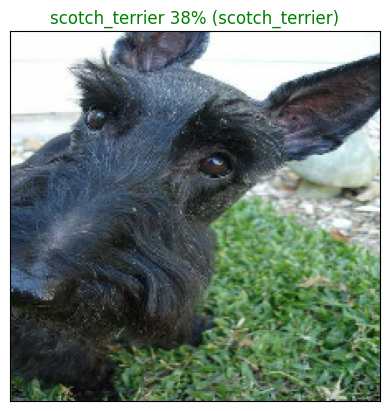

In [ ]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

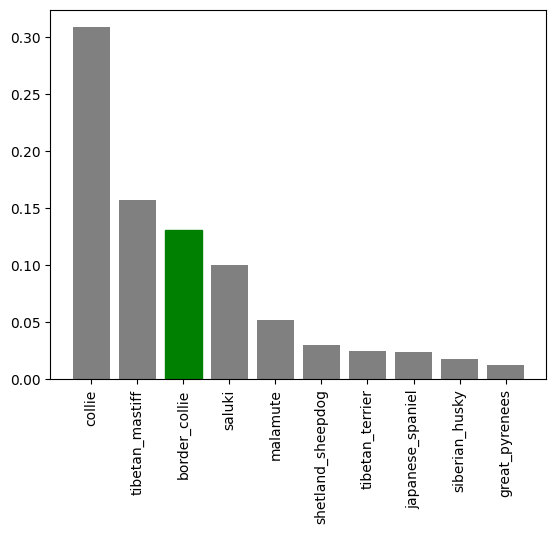

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

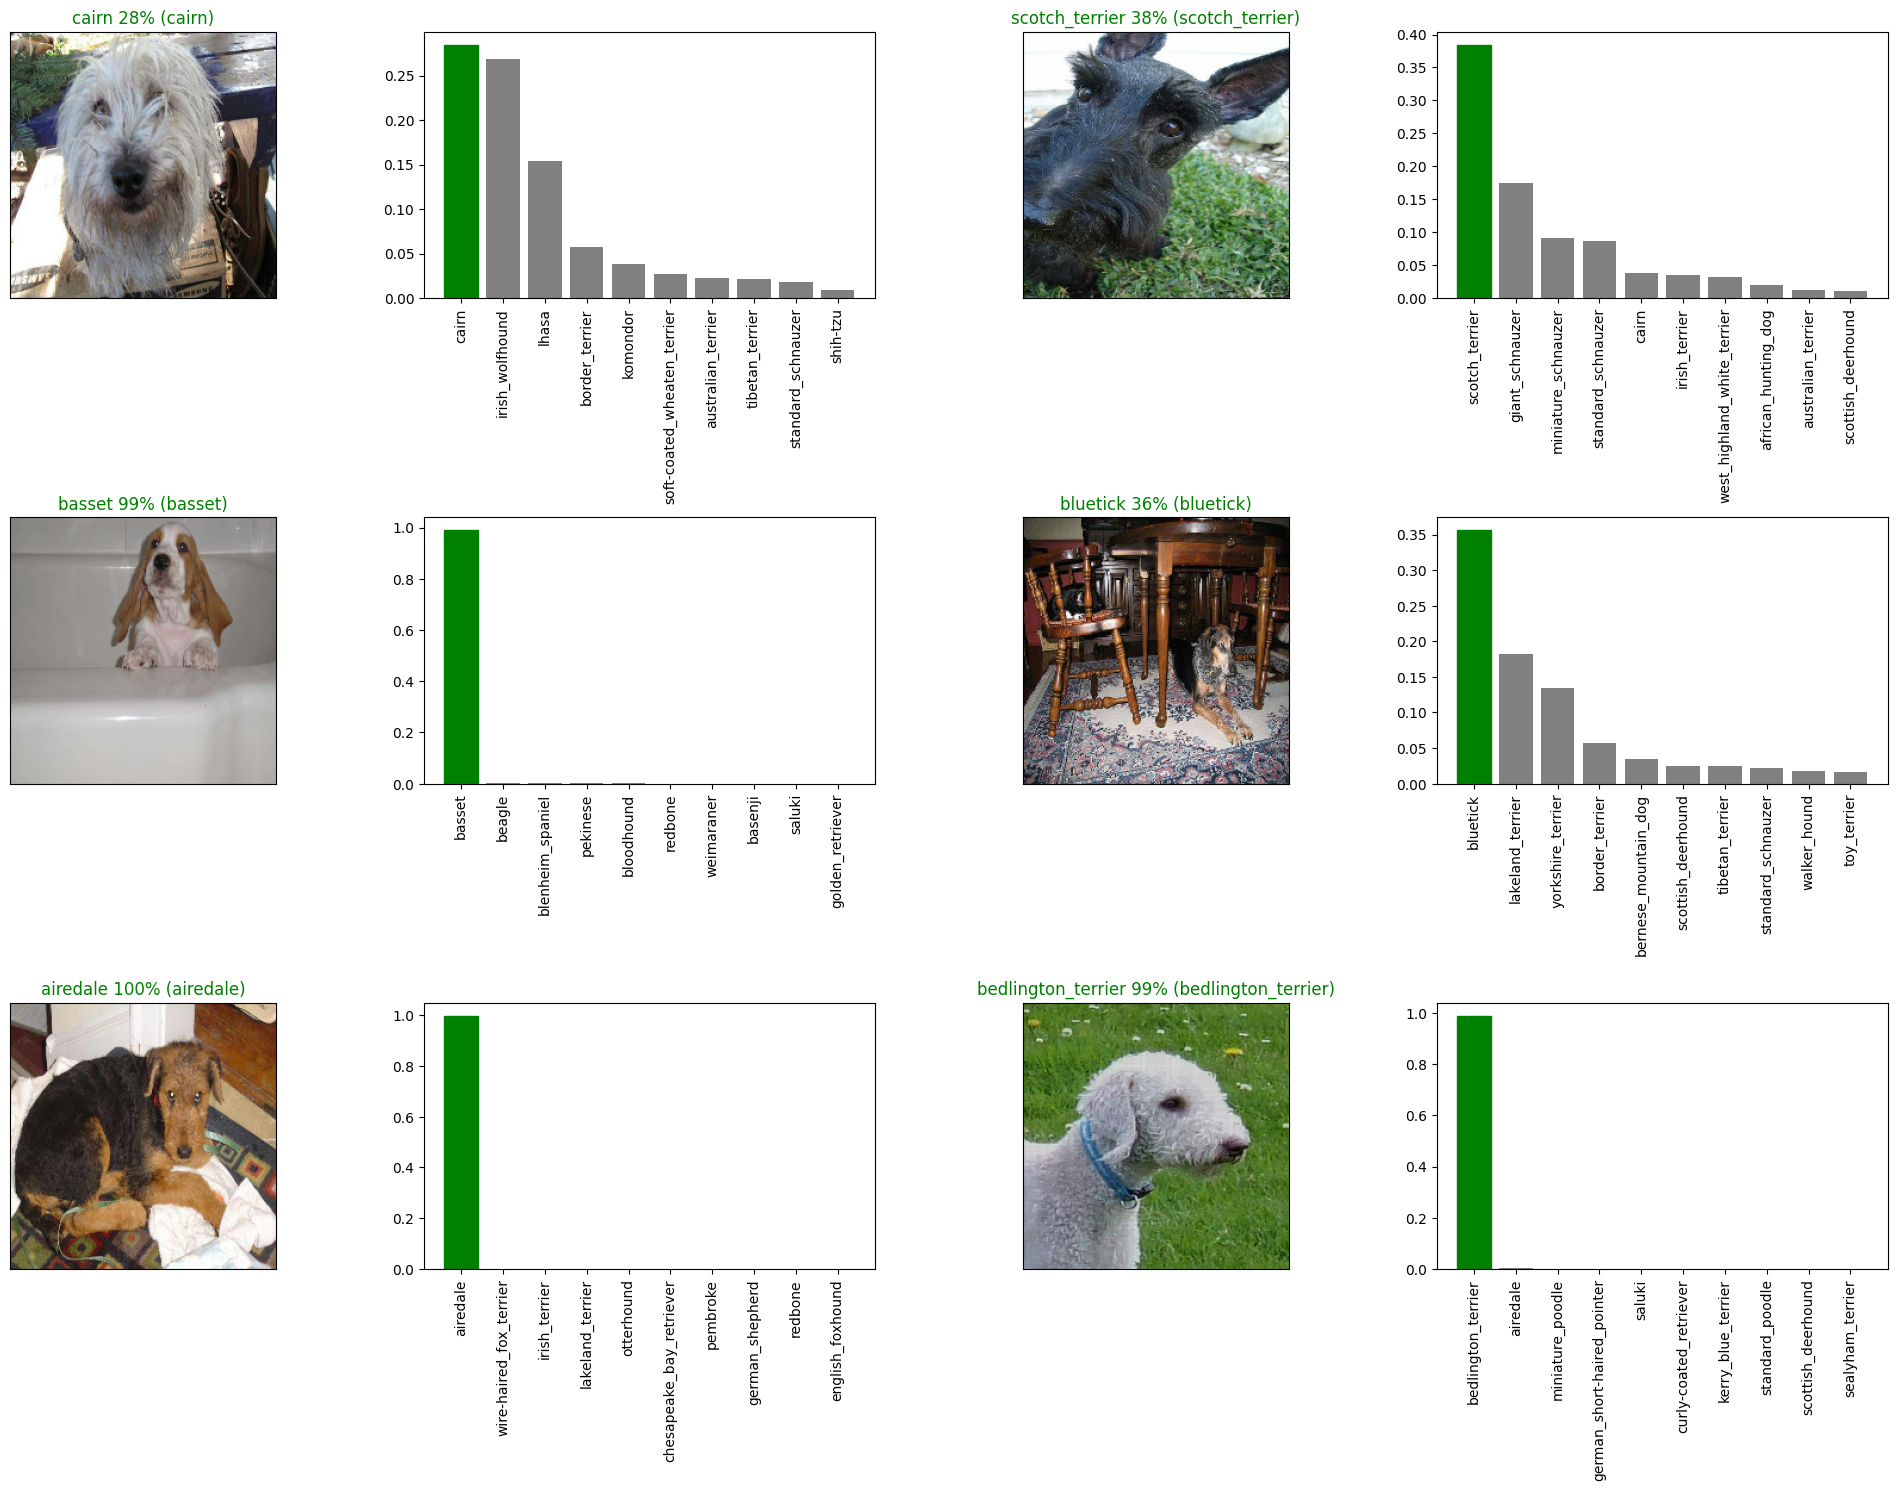

In [ ]:
# Check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading the model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("/content/drive/MyDrive/Dog Vision/models/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save the model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: /content/drive/MyDrive/Dog Vision/models/20231024-07241698132257-1000-images-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Dog Vision/models/20231024-07241698132257-1000-images-Adam.h5'

In [ ]:
# Load the model trained on 1000 images
model_1000_images = load_model('/content/drive/MyDrive/Dog Vision/models/20231024-07241698132257-1000-images-Adam.h5')

Loading saved model from: /content/drive/MyDrive/Dog Vision/models/20231024-07241698132257-1000-images-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 77ms/step - loss: 1.2851 - accuracy: 0.6800


[1.2851399183273315, 0.6800000071525574]

In [ ]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 1s 73ms/step - loss: 1.2851 - accuracy: 0.6800


[1.2851399183273315, 0.6800000071525574]

## Training a model (on the full data)

In [ ]:
# Size of the full dataset
len(X), len(y)

(10222, 10222)

In [ ]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1672s 5s/step - loss: 1.3577 - accuracy: 0.6684
Epoch 2/100
320/320 [==============================] - 30s 93ms/step - loss: 0.4078 - accuracy: 0.8813
Epoch 3/100
320/320 [==============================] - 30s 94ms/step - loss: 0.2414 - accuracy: 0.9355
Epoch 4/100
320/320 [==============================] - 30s 94ms/step - loss: 0.1560 - accuracy: 0.9627
Epoch 5/100
320/320 [==============================] - 29s 92ms/step - loss: 0.1060 - accuracy: 0.9796
Epoch 6/100
320/320 [==============================] - 30s 93ms/step - loss: 0.0771 - accuracy: 0.9869
Epoch 7/100
320/320 [==============================] - 30s 94ms/step - loss: 0.0589 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 30s 93ms/step - loss: 0.0479 - accuracy: 0.9924
Epoch 9/100
320/320 [==============================] - 30s 93ms/step - loss: 0.0384 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 30s 94ms/step - l

### Saving and reloading the full model

In [ ]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")

In [ ]:
# Load in the full model
loaded_full_model = load_model('/content/drive/MyDrive/Dog Vision/models/20200131-03111580440309-all-images-Adam.h5')

### Making predictions on the test dataset

In [ ]:
# Load test image filenames
test_path = "/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e0165801e47527205e45295aba441972.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e5657f523cf994628f63b673c88e9112.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e3a43510b5f90bfb9fb050c77cabb079.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/df624595296500c98e3a1bf4d9ea917b.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e3a7aeb038b8abd3f8ed910c84504efc.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e6c9d8058cbc9b1665aecac1ae179288.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e5ba665e01b6927411d60158f28160dd.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e137b0cd96051765c349377725c4696d.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identification/test/e64b15ca154304104fe95ded7338858e.jpg',
 '/content/drive/MyDrive/Dog Vision/dog-breed-identific

In [ ]:
# How many test images are there?
len(test_filenames)

10357

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


**Note:** Running the cell below may take up to an hour.

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 2934s 9s/step


In [ ]:
# Check out the test predictions
test_predictions[:10]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, ...,
        1.06917716e-13, 1.58530451e-08, 1.52161670e-06],
       [3.17894322e-10, 3.20088262e-14, 1.85374840e-10, ...,
        7.00588814e-08, 1.88822238e-08, 2.56980937e-10],
       [4.27301083e-09, 1.84139528e-13, 1.11784948e-09, ...,
        2.71949238e-12, 2.23927123e-06, 7.41860809e-11],
       ...,
       [4.47232779e-10, 4.28004029e-07, 4.11986996e-08, ...,
        4.65437893e-07, 8.21722967e-10, 8.86002116e-09],
       [3.50528079e-11, 1.94377336e-03, 1.44941642e-10, ...,
        1.56135718e-06, 6.13228721e-08, 7.32120961e-12],
       [1.23221771e-08, 3.08354520e-09, 1.87174110e-10, ...,
        8.16165635e-10, 9.98905063e-01, 6.73740752e-09]], dtype=float32)

## Making predictions on custom images

In [4]:
# Get custom image filepaths
custom_path = "/content/drive/MyDrive/Dog Vision"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['golden_retriever', 'labrador_retriever', 'lakeland_terrier']

In [ ]:
# Get custom images
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

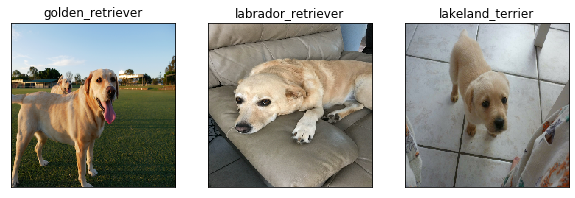

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)